# Heterodyne setup

This notebook focuses on metodologies presented in the work: 

[Time-dependent laser linewidth - beat-note digital acquisition and numerical analysis (2016)](https://opg.optica.org/oe/fulltext.cfm?uri=oe-24-24-27961&id=355513)

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from optic.models.devices import photodiode, basicLaserModel
from optic.utils import parameters

fontSmall = {'family':'serif', 'weight':'normal', 'size':12}
font = {'family':'serif', 'weight':'normal', 'size':16}
fontTitle = {'family':'serif', 'weight':'normal', 'size':20}

![Heterodyne Setup](IlustrationMedia/HeterodyneSetup.png)

1000


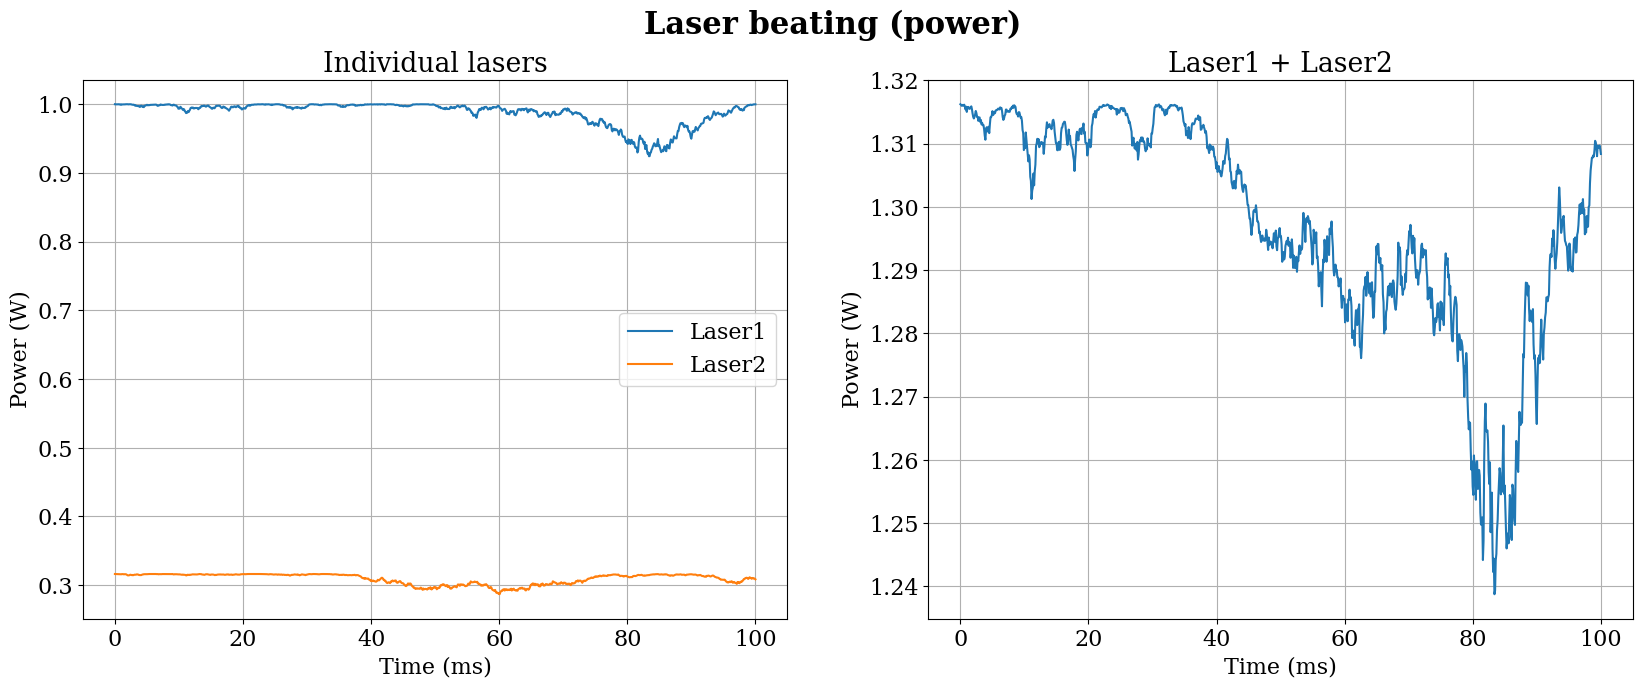

In [120]:
A1 = 1
A2 = 1


Nsamples = 1000
tArray = np.linspace(0,0.1,Nsamples)

LaserParam1 = parameters()  # OptiCommPy default class for parameters (struct)
LaserParam1.P = 30
LaserParam1.lw = 0.1
LaserParam1.RIN_var = 1e-22
LaserParam1.Fs = 5e3
LaserParam1.Ns = Nsamples

LaserParam2 = parameters()  # OptiCommPy default class for parameters (struct)
LaserParam2.P = 20
LaserParam2.lw = 0.1
LaserParam2.RIN_var = 1e-22
LaserParam2.Fs = 5e3
LaserParam2.Ns = Nsamples


Laser1 = basicLaserModel(LaserParam1)
Laser2 = basicLaserModel(LaserParam2)

print(np.size(Laser1))

plt.rc('font',**font)
figure, ax = plt.subplots(1,2,figsize=(20,7))
figure.suptitle(f'Laser beating (power)',fontsize=22, weight='bold')

ax[0].plot(tArray*1e3,Laser1,label='Laser1')
ax[0].plot(tArray*1e3,Laser2,label='Laser2')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Power (W)')
ax[0].set_title('Individual lasers')
ax[0].grid()
ax[0].legend()

ax[1].plot(tArray*1e3,Laser1+Laser2)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Power (W)')
ax[1].set_title('Laser1 + Laser2')
ax[1].grid()

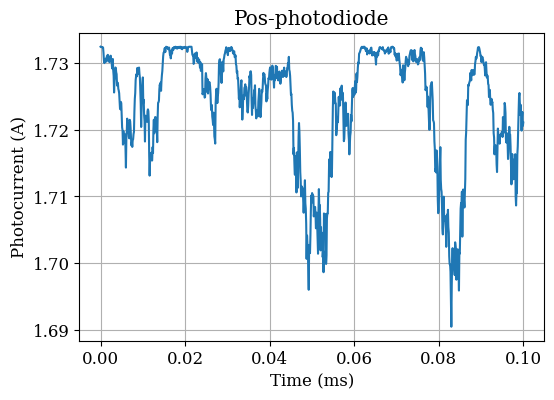

In [117]:
plt.rc('font',**fontSmall)
plt.figure(figsize=(6,4))
plt.plot(tArray,photodiode(Laser1+Laser2))
plt.xlabel('Time (ms)')
plt.ylabel('Photocurrent (A)')
plt.title('Pos-photodiode')
plt.grid()